In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.metrics import MeanIoU
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from segmentation_models import get_preprocessing
from keras.applications.imagenet_utils import preprocess_input
import segmentation_models as sm

from tqdm import tqdm
import os
import numpy as np
import cv2

# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)



Segmentation Models: using `keras` framework.


In [2]:
parent_directory = "Dataset\images"

for i in os.listdir(parent_directory):
    print(f'{i} ---> {len(os.listdir(os.path.join(parent_directory, i)))}')

Astrocytoma ---> 529
Glioblastoma ---> 732
Gliomas ---> 1237
Meningioma ---> 640
Neurocytoma ---> 176


In [3]:
SIZE_X = 256
SIZE_Y = 256
IMAGES_FROM_CLASS = 300
TOTAL_CLASSES = 6

In [4]:
image_directory = r"Dataset\images";
mask_directory = r"Dataset\masks";

train_images = []
train_masks = []

class_labels = [i for i in os.listdir(image_directory)]

for class_name in tqdm(os.listdir(image_directory)):
    image_class_path = os.path.join(image_directory, class_name)
    mask_class_path = os.path.join(mask_directory, class_name)

    for filename in tqdm(os.listdir(image_class_path)[:IMAGES_FROM_CLASS]):
        image_path = os.path.join(image_class_path, filename)
        mask_path = os.path.join(mask_class_path, filename[:-4] + "_mask" + filename[-4:])
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue

        image = cv2.resize(image, (SIZE_X, SIZE_Y))
        # image = image/255.

        mask = cv2.imread(mask_path, 0)
        if mask is None:
            print(f"Failed to read mask: {mask_path}")
            continue

        mask = cv2.resize(mask, (SIZE_X, SIZE_Y), interpolation = cv2.INTER_NEAREST)
        mask = mask / 255.
        mask[mask == 1] += class_labels.index(class_name)

        train_images.append(image)
        train_masks.append(mask)

        # print(np.unique(mask))


100%|██████████| 5/5 [00:21<00:00,  4.21s/it]


In [5]:
image_directory = r"Dataset\images";
mask_directory = r"Dataset\masks";

validation_images = []
validation_masks = []

class_labels = [i for i in os.listdir(image_directory)]

for class_name in tqdm(os.listdir(image_directory)):
    image_class_path = os.path.join(image_directory, class_name)
    mask_class_path = os.path.join(mask_directory, class_name)

    if class_name == "Neurocytoma":
        IMAGES_FROM_CLASS = 75
    else:
        IMAGES_FROM_CLASS = 300

    for filename in tqdm(os.listdir(image_class_path)[IMAGES_FROM_CLASS:IMAGES_FROM_CLASS+100]):
        image_path = os.path.join(image_class_path, filename)
        mask_path = os.path.join(mask_class_path, filename[:-4] + "_mask" + filename[-4:])
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            continue

        image = cv2.resize(image, (SIZE_X, SIZE_Y))
        # image = image/255.

        mask = cv2.imread(mask_path, 0)
        if mask is None:
            print(f"Failed to read mask: {mask_path}")
            continue

        mask = cv2.resize(mask, (SIZE_X, SIZE_Y), interpolation = cv2.INTER_NEAREST)
        mask = mask / 255.
        mask[mask == 1] += class_labels.index(class_name)

        validation_images.append(image)
        validation_masks.append(mask)

        # print(np.unique(mask))


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


In [6]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)

print(train_images.shape)
print(train_masks.shape)

(1376, 256, 256, 3)
(1376, 256, 256)


In [7]:
validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

print(validation_images.shape)
print(validation_masks.shape)

(500, 256, 256, 3)
(500, 256, 256)


In [8]:
train_masks = np.expand_dims(train_masks, axis=3)
validation_masks = np.expand_dims(validation_masks, axis=3)

In [9]:
print(train_images.shape)
print(train_masks.shape)

print(validation_images.shape)
print(validation_masks.shape)

(1376, 256, 256, 3)
(1376, 256, 256, 1)
(500, 256, 256, 3)
(500, 256, 256, 1)


In [10]:
train_masks = to_categorical(train_masks, num_classes=TOTAL_CLASSES)
validation_masks = to_categorical(validation_masks, num_classes=TOTAL_CLASSES)

In [11]:
print(train_images.shape)
print(train_masks.shape)

print(validation_images.shape)
print(validation_masks.shape)

(1376, 256, 256, 3)
(1376, 256, 256, 6)
(500, 256, 256, 3)
(500, 256, 256, 6)


In [12]:
# Generate a permutation of indices
indices = np.arange(len(train_images))
np.random.shuffle(indices)

# Apply the permutation to both arrays in place
train_images[:] = train_images[indices]
train_masks[:] = train_masks[indices]

In [13]:
# Generate a permutation of indices
indices = np.arange(len(validation_images))
np.random.shuffle(indices)

# Apply the permutation to both arrays in place
validation_images[:] = validation_images[indices]
validation_masks[:] = validation_masks[indices]

In [14]:
np.unique(train_masks)
np.unique(validation_masks)

array([0., 1.], dtype=float32)

In [15]:
print(train_images.shape)
print(train_masks.shape)

print(validation_images.shape)
print(validation_masks.shape)

(1376, 256, 256, 3)
(1376, 256, 256, 6)
(500, 256, 256, 3)
(500, 256, 256, 6)


In [32]:

activation='softmax'
class_weights = [0.000167, 0.764, 0.764, 0.764, 0.764, 1.304]
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [33]:
filepath = "checkpoints/improvement - {val_iou_score:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_iou_score', save_best_only= True, mode = 'max')

early_stopping = keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=10, min_delta=0.01, mode="max")

callbacks_list = [checkpoint, early_stopping]

In [34]:
BACKBONE = "inceptionresnetv2"
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
train_images = preprocess_input(train_images)
validation_images = preprocess_input(validation_images)

In [35]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=TOTAL_CLASSES, activation=activation)

In [36]:
model.compile(optim, total_loss, metrics=metrics)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [38]:
with tf.device('/cpu:0'):
    training = model.fit(train_images, train_masks, validation_data = (validation_images, validation_masks), batch_size=16, epochs=20, verbose=1, callbacks=callbacks_list)

Epoch 1/20
86/86 [==============================] - 1430s 16s/step - loss: 1.0249 - iou_score: 0.1089 - f1-score: 0.1644 - val_loss: 1.0138 - val_iou_score: 0.1881 - val_f1-score: 0.2791
Epoch 2/20
86/86 [==============================] - 1409s 16s/step - loss: 0.9549 - iou_score: 0.3622 - f1-score: 0.5073 - val_loss: 0.9579 - val_iou_score: 0.2771 - val_f1-score: 0.3966
Epoch 3/20
86/86 [==============================] - 1409s 16s/step - loss: 0.8779 - iou_score: 0.4742 - f1-score: 0.6226 - val_loss: 0.8962 - val_iou_score: 0.3262 - val_f1-score: 0.4526
Epoch 4/20
86/86 [==============================] - 1408s 16s/step - loss: 0.7610 - iou_score: 0.4841 - f1-score: 0.6165 - val_loss: 0.7665 - val_iou_score: 0.4597 - val_f1-score: 0.5910
Epoch 5/20
86/86 [==============================] - 1410s 16s/step - loss: 0.6917 - iou_score: 0.5803 - f1-score: 0.7012 - val_loss: 0.7036 - val_iou_score: 0.5443 - val_f1-score: 0.6613
Epoch 6/20
86/86 [==============================] - 1407s 16s/ste

In [39]:
best_model = keras.models.load_model(r"checkpoints\improvement - 0.61.keras", compile=False)

In [228]:
test_image = cv2.imread(r"Dataset\images\Astrocytoma\Astrocytoma_T1_000.tif")
test_image = cv2.resize(test_image, (SIZE_X, SIZE_Y))

cv2.imshow("astrocytoma", test_image)
cv2.waitKey(0)
cv2.destroyAllWindows() 

# test_image = image/255.


In [229]:
test_image.shape

(256, 256, 3)

In [230]:
test_image_model = np.expand_dims(test_image, 0)

In [231]:
test_image_model = preprocess_input(test_image_model)

In [232]:
predicted_mask = best_model.predict(test_image_model)

1/1 [==============================] - 0s 46ms/step


In [233]:
predicted_mask.shape

(1, 256, 256, 6)

In [234]:
predicted_mask = np.squeeze(predicted_mask, axis=0)

In [235]:
predicted_mask.shape

(256, 256, 6)

In [236]:
predicted_mask = predicted_mask * 255.

In [237]:
predicted_mask = np.argmax(predicted_mask, axis = -1)


In [238]:
predicted_mask.shape


(256, 256)

In [239]:
np.unique(predicted_mask)

array([0, 1, 2, 3, 4, 5], dtype=int64)

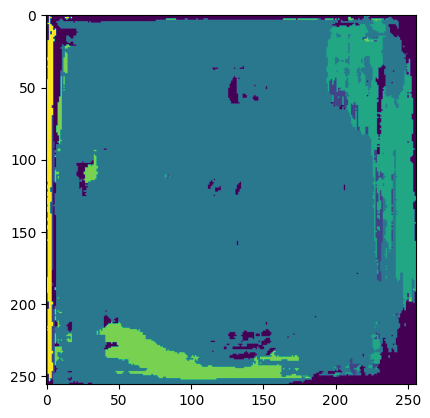

In [240]:
import matplotlib.pyplot as plt

plt.imshow(predicted_mask)
plt.show()

In [241]:
# Assuming your predicted_mask is of shape (256, 256) with values [0, 1, 2, 3, 4, 5]
# Define a color map for the classes (0 = black, 1 = red, 2 = green, 3 = blue, etc.)
color_map = {
    0: [0, 0, 0],       # Black for background
    1: [255, 0, 0],     # Red for class 1
    2: [0, 255, 0],     # Green for class 2
    3: [0, 0, 255],     # Blue for class 3
    4: [255, 255, 0],   # Yellow for class 4
    5: [255, 0, 255],   # Magenta for class 5
}

In [242]:
colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)


In [243]:
colored_mask.shape

(256, 256, 3)

In [244]:

for class_value, color in color_map.items():
    colored_mask[predicted_mask == class_value] = color

In [245]:
colored_mask.shape

(256, 256, 3)

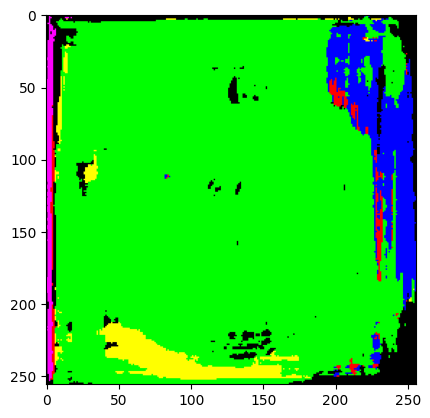

In [246]:
import matplotlib.pyplot as plt

plt.imshow(colored_mask)
plt.show()

In [247]:
print(test_image.shape)
print(colored_mask.shape)

print(test_image.dtype)
print(colored_mask.dtype)

(256, 256, 3)
(256, 256, 3)
uint8
uint8


In [190]:
# # Step 1: Clip values to [0, 1] range (optional but good practice)
# test_image_clipped = np.clip(test_image, 0, 1)

# # Step 2: Scale the values to [0, 255]
# test_image_scaled = test_image_clipped * 255

# # Step 3: Convert to uint8
# test_image = test_image.astype(np.uint8)

In [248]:
print(test_image.shape)
print(colored_mask.shape)

print(test_image.dtype)
print(colored_mask.dtype)

(256, 256, 3)
(256, 256, 3)
uint8
uint8


In [249]:
masked_image = cv2.addWeighted(test_image, 0.2, colored_mask, 0.8, 0)

# Concatenate the test image and masked image side by side
display_image = cv2.hconcat([test_image, masked_image])

# Display the image
cv2.imshow("astrocytoma", display_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
